In [1]:
import numpy as np
import scipy.linalg as sla
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from time import time

import localpsfcpp as lpsf

In [2]:
def plot_ellipse(mu, Sigma, n_std_tau, ax=None, **kwargs):
    # Usage:
    #   https://github.com/NickAlger/nalger_helper_functions/tree/master/jupyter_notebooks/plot_ellipse.ipynb
    if ax is None:
        ax = plt.gca()

    ee, V = np.linalg.eigh(Sigma)
    e_big = ee[1]
    e_small = ee[0]
    v_big = V[:, 1]
    theta = np.arctan(v_big[1] / v_big[0]) * 180. / np.pi

    long_length = n_std_tau * 2. * np.sqrt(e_big)
    short_length = n_std_tau * 2. * np.sqrt(e_small)

    if not ('facecolor' in kwargs):
        kwargs['facecolor'] = 'none'

    if not ('edgecolor' in kwargs):
        kwargs['edgecolor'] = 'k'

    ellipse = Ellipse(mu, width=long_length, height=short_length, angle=theta, **kwargs)
    ax.add_artist(ellipse)

(-0.25, 1.25)

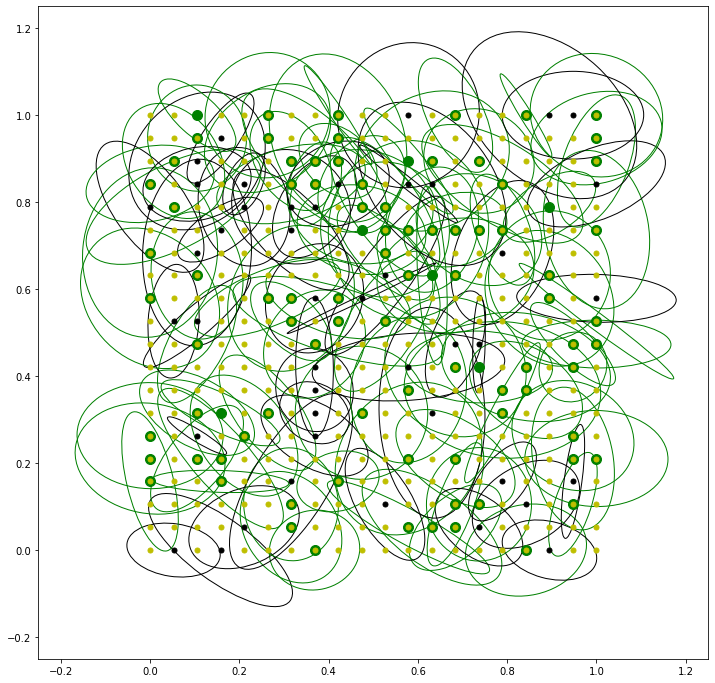

In [3]:
nx = 20
ny = 20
scaling_factor = 0.01
tau = 1.3
min_vol_rtol = 0.2

X, Y = np.meshgrid(np.linspace(0,1,nx), np.linspace(0,1,nx))
pp = np.vstack([X.reshape(-1), Y.reshape(-1)])
num_ellipsoids = pp.shape[1]
all_vol = list(np.random.rand(num_ellipsoids))
all_mu = list(pp.T)
all_Sigma0 = list()
for ii in range(num_ellipsoids):
    M = np.random.randn(2,2)
    all_Sigma0.append(scaling_factor * 0.5 * (M + M.T))
    
all_Sigma_is_good = [np.all(np.linalg.eigh(S)[0] >= 0) for S in all_Sigma0]
all_Sigma = [sla.sqrtm(np.dot(S.T, S)) for S in all_Sigma0]

all_points = all_mu

plt.figure(figsize=(12,12))
for k in range(num_ellipsoids):
    vol_is_good = all_vol[k] >= (min_vol_rtol * np.max(all_vol))
    Sigma_is_good = all_Sigma_is_good[k]
    
    if not vol_is_good:
        plt.plot(all_points[k][0], all_points[k][1], '.g', markersize=20)
        plot_ellipse(all_mu[k], all_Sigma[k], tau, edgecolor='g')
        
    if not Sigma_is_good:
        plt.plot(all_points[k][0], all_points[k][1], '.y', markersize=10)
        
    if Sigma_is_good and vol_is_good:
        plot_ellipse(all_mu[k], all_Sigma[k], tau)
        plt.plot(all_points[k][0], all_points[k][1], '.k', markersize=10)
    
plt.xlim(-0.25, 1.25)
plt.ylim(-0.25, 1.25)

In [4]:
aabb = lpsf.make_ellipsoid_aabbtree(all_mu, all_Sigma, tau)

400 0 0
14
0 14 386
11
0 25 375
8
0 33 367
5
0 38 362
3
0 41 359
1
0 42 358
1
0 43 357
1
0 44 356
0
0 44 356


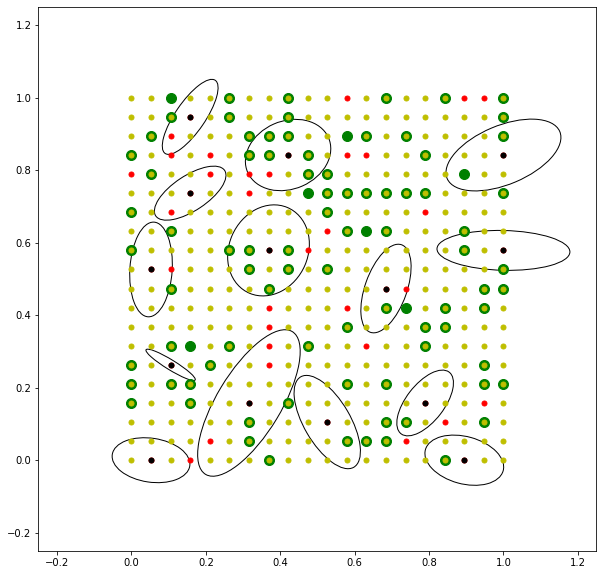

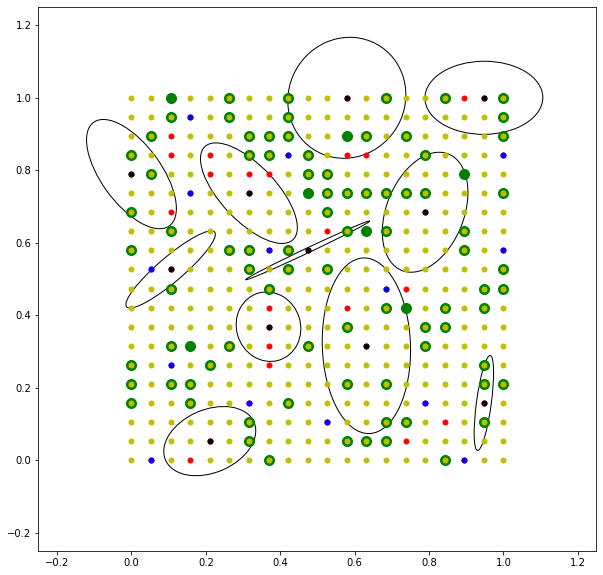

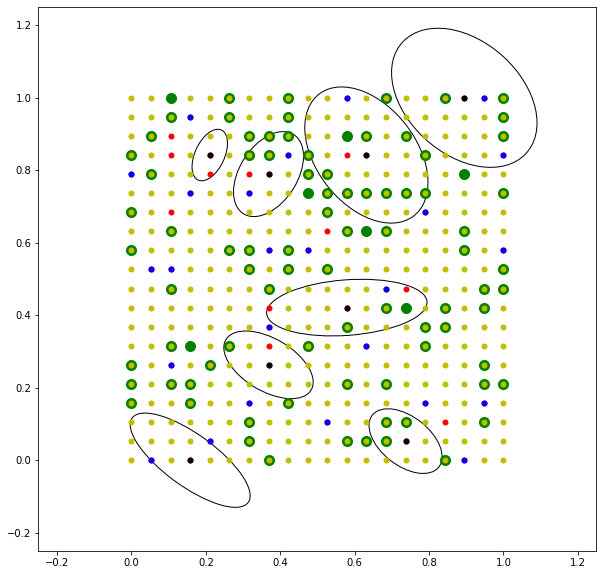

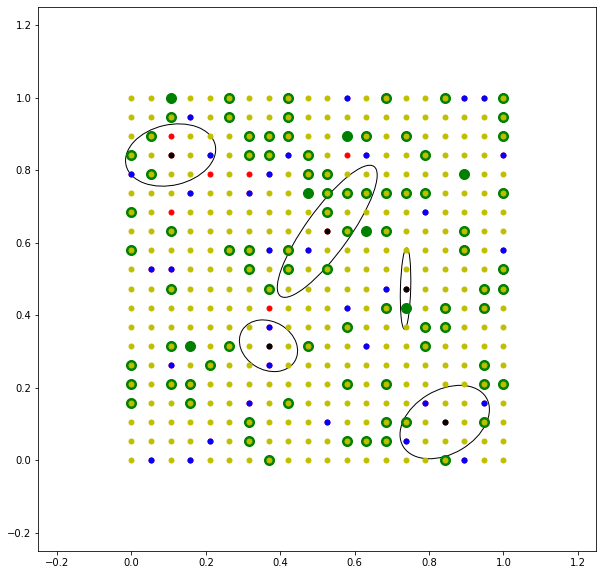

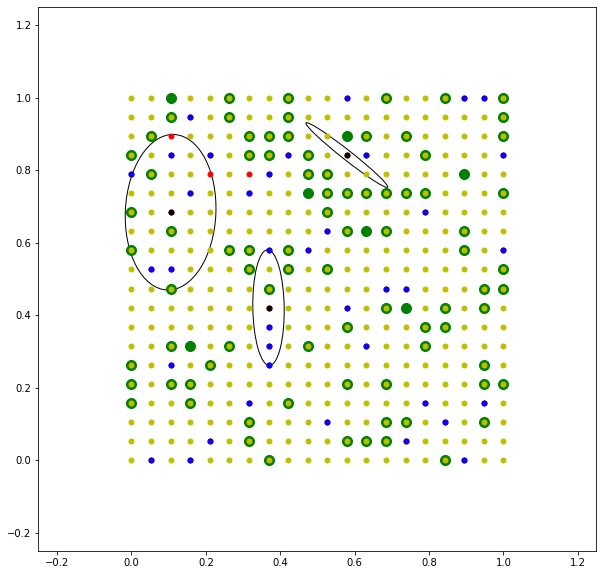

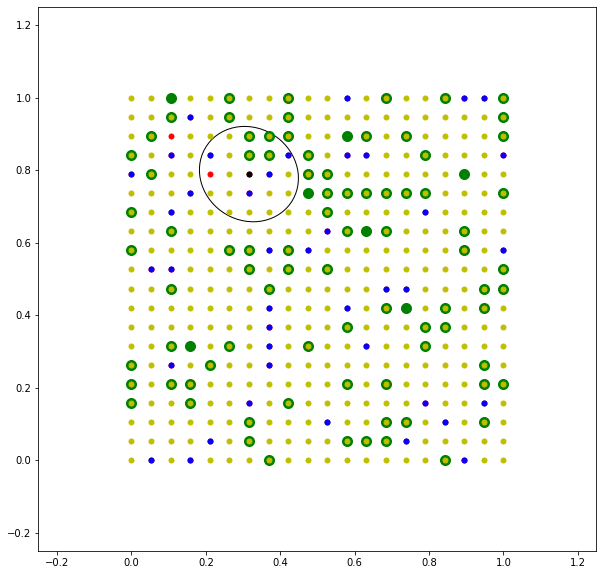

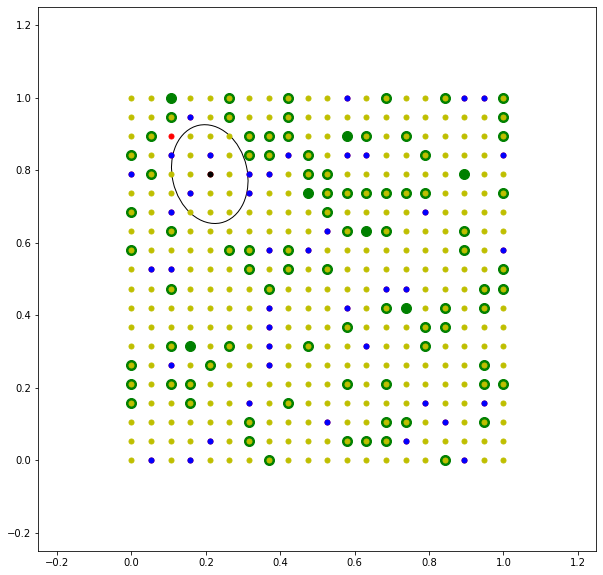

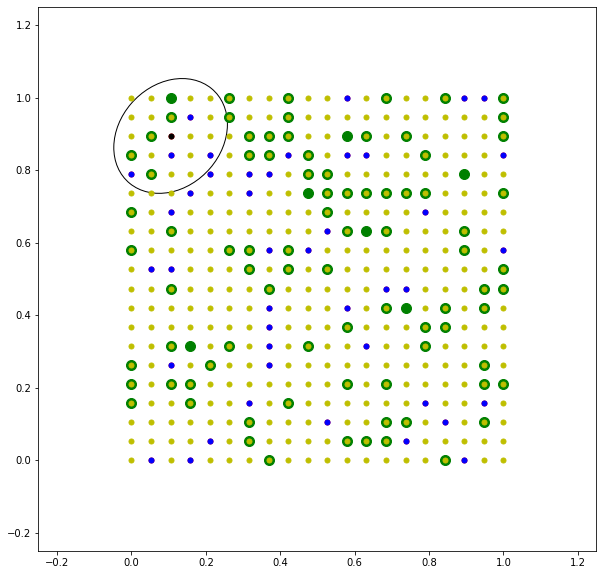

In [5]:
batches = [[]]
squared_distances = list(-1.0 * np.ones(len(all_points)))

print(np.sum(np.array(squared_distances) < 0), np.sum(np.array(squared_distances) == 0), np.sum(np.array(squared_distances) > 0))

new_batch, squared_distances = lpsf.pick_ellipsoid_batch(batches, squared_distances, all_points,
                                                         all_vol, all_mu, all_Sigma, all_Sigma_is_good, tau, 
                                                         aabb, min_vol_rtol)

print(len(new_batch))

print(np.sum(np.array(squared_distances) < 0), np.sum(np.array(squared_distances) == 0), np.sum(np.array(squared_distances) > 0))

while new_batch:
    batches.append(new_batch)
    
    plt.figure(figsize=(10,10))
    for k in range(num_ellipsoids):
        vol_is_good = all_vol[k] >= (min_vol_rtol * np.max(all_vol))
        Sigma_is_good = all_Sigma_is_good[k]

        if not vol_is_good:
            plt.plot(all_points[k][0], all_points[k][1], '.g', markersize=20)

        if not Sigma_is_good:
            plt.plot(all_points[k][0], all_points[k][1], '.y', markersize=10)
            
        if vol_is_good and Sigma_is_good:
            plt.plot(all_points[k][0], all_points[k][1], '.r', markersize=10)
            
    for b_old in batches[:-1]:
        for ind_old in b_old:
            plt.plot(all_points[ind_old][0], all_points[ind_old][1], '.b', markersize=10)
    
    for ind in new_batch:
        plot_ellipse(all_mu[ind], all_Sigma[ind], tau)
        plt.plot(all_points[ind][0], all_points[ind][1], '.k', markersize=10)

    plt.xlim(-0.25, 1.25)
    plt.ylim(-0.25, 1.25)
    
    new_batch, squared_distances = lpsf.pick_ellipsoid_batch(batches, squared_distances, all_points, 
                                                             all_vol, all_mu, all_Sigma, all_Sigma_is_good, tau, 
                                                             aabb, min_vol_rtol)
    
    print(len(new_batch))
    print(np.sum(np.array(squared_distances) < 0), np.sum(np.array(squared_distances) == 0), np.sum(np.array(squared_distances) > 0))

In [6]:
num_ellipsoids = 10000
scaling_factor = 0.005
tau = 1.3
min_vol_rtol = 0.2

pp = [np.random.rand(2) for _ in range(num_ellipsoids)]
all_vol = list(np.random.rand(num_ellipsoids))
all_mu = pp
all_Sigma0 = list()
for ii in range(num_ellipsoids):
    M = np.random.randn(2,2)
    all_Sigma0.append(scaling_factor * 0.5 * (M + M.T))
    
all_Sigma_is_good = [np.all(np.linalg.eigh(S)[0] >= 0) for S in all_Sigma0]
all_Sigma = [sla.sqrtm(np.dot(S.T, S)) for S in all_Sigma0]

all_points = all_mu


t = time()
aabb = lpsf.make_ellipsoid_aabbtree(all_mu, all_Sigma, tau)
dt_aabb_build = time() - t
print('num_ellipsoids=', num_ellipsoids, ', dt_aabb_build=', dt_aabb_build)

batches = [[]]
squared_distances = list(-1.0 * np.ones(len(all_points)))
t = time()
for k in range(25):
    new_batch, squared_distances = lpsf.pick_ellipsoid_batch(batches, squared_distances, all_points,
                                                             all_vol, all_mu, all_Sigma,  all_Sigma_is_good, tau, 
                                                             aabb, min_vol_rtol)
    batches.append(new_batch)
dt_batches = time() - t
print('num_ellipsoids=', num_ellipsoids, ', dt_batches=', dt_batches)

num_ellipsoids= 10000 , dt_aabb_build= 0.031213998794555664
num_ellipsoids= 10000 , dt_batches= 0.6469924449920654
